# Spectral mixing and unmixing in fluorescence microscopy

In fluorescence microscopy, different fluorescent probes can be used to label different structures or proteins. Since the excitation and emission spectra of the probes are relatively broad, there can be considerable mixing of the signals The mixing of the emitted signals is generally indicated as 'crosstalk' or 'bleed-through'. The most popular strategy to avoid mixing is to optimize the combination of probes in such a way that spectral overlap is minimized. This poses several restrictions on the number of probes and their emission spectrum. Another way to deal with mixing is to correct for it by 'spectral unmixing' [(doi:10.1016/S0014-5793(03)00521-0)](https://doi.org/10.1016/S0014-5793(03)00521-0). This is readily achieved when (i) the number of detection channels is equal or higher than the number of probes and (ii) the emission profile of the individual probes is available (either from measurements or a theoretical calculation). Below the mixing and unmixing of the emission signals is demonstrated.

First, the necessary libraries are loaded:

In [2]:
import skimage
import matplotlib.pyplot as plt
import numpy as np


Check and change working dir:

In [3]:
%pwd

'/Users/joachimgoedhart/surfdrive/Python/Image_analysis'

In [4]:
%cd Synthetic_data

/Users/joachimgoedhart/surfdrive/Python/Image_analysis/Synthetic_data


## 1. Overdetermined systems (channels > probes)
In case we have more spectral changgels than fluorescent probes, we have an 'overdetermined' system [(doi:10.1016/S0014-5793(03)00521-0)](https://doi.org/10.1016/S0014-5793(03)00521-0). Below, we illustrate the case where we have two probes and 8 emission channels.

We load a synthetic image with the two objects (reflecting two emission colors). In each image, a different object is visible at a unique location. The images reflect the distribution of the object and correspond to the pure signal emitted by the object.

In [4]:
im_raw = skimage.io.imread("Synthetic-2obj.tif")

Let's look at the dimensions:

In [5]:
im_raw.shape

(2, 256, 256)

From the dimensions, we can infer that the image stack consists of 2 images that each are 256x256 pixels. To show the first image of the stack (python counts from zero):

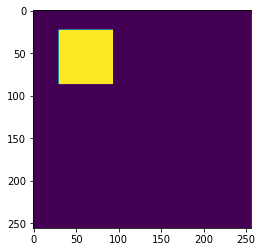

In [6]:
plt.imshow(im_raw[0])

### 1.1 Mix

Let's plot the two images of the stack:

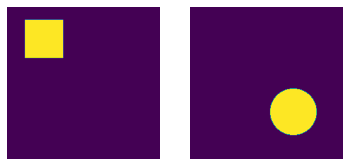

In [7]:

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(im_raw[i])
    plt.axis('off')
plt.show()


These two objects represent two structures, labeled with two different probes that have a unique emission profile. The spectral profile is defined in a matrix and we add this information by multiplying the images with a mixing matrix. 
In this matrix (mix), the column reflects the emission of an object in the 8 channels. The sum of each column is normalized to 1.

In [8]:
mix = np.array(
    [[0.05, 0.],
     [0.50, 0.05],
     [0.25, 0.6],
     [0.15, 0.15],
     [0.05, 0.1],
     [0,    0.05],
     [0,    0.03],
     [0,    0.02]
    ])

Just a check whether this matrix is correctly assigned:

In [9]:
mix

array([[0.05, 0.  ],
       [0.5 , 0.05],
       [0.25, 0.6 ],
       [0.15, 0.15],
       [0.05, 0.1 ],
       [0.  , 0.05],
       [0.  , 0.03],
       [0.  , 0.02]])

Let's mix the synthetic image with the mixing matrix:

In [10]:
mixed = np.einsum('ji,ikl->jkl', mix, im_raw)

Checking the shape of the new array:

In [11]:
mixed.shape

(8, 256, 256)

The resulting data, shows the distribution of the fluorescence over 8 channels. Let's plot the result:

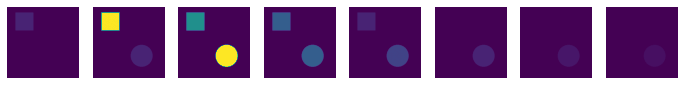

In [12]:
plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(mixed[i], vmin=0, vmax=128)
    plt.axis('off')
plt.show()

The signal is now distributed over multiple channels. The maximal signal of the square object is in channel 2 and that of the round object in channel 3.
This distribution of the signal corresponds with the mixing matrix (mix).

The resulting stack is a realistic set of images acquired from objects that emit at different wavelengths. When we know (and here we do!) the mixing matrix, we can use that to _unmix_ the data and show the distribution of the pure components.

### 1.2 Unmix

We have an _overdetermined_ system, with more channels than objects. The mixing matrix is not square, so we cannot simply invert the mixing matrix. We use the equation in Novo et al. (2013), [DOI: 10.1002/cyto.a.22272](https://dx.doi.org/10.1002/cyto.a.22272) to arrive at an umixing matrix:

(M<sup>T</sup>M)<sup>-1</sup>M<sup>T</sup>

The transposed matrix M<sup>T</sup> is calculated like this:

In [13]:
t_mix = np.einsum('ij->ji', mix)

Now, we can calculate the unmixing matrix according to (M<sup>T</sup>M)<sup>-1</sup>M<sup>T</sup>:

In [14]:
inv_mix = np.matmul(np.linalg.inv(np.matmul(t_mix,mix)), t_mix)

Let's inspect the unmixing matrix:

In [15]:
inv_mix

array([[ 0.210814  ,  2.00109425, -0.23047869,  0.31130482, -0.00327745,
        -0.10704572, -0.06422743, -0.04281829],
       [-0.10704572, -0.89072614,  1.62154447,  0.2180561 ,  0.25241646,
         0.17973109,  0.10783865,  0.07189244]])

In [16]:
inv_mix.shape

(2, 8)

When the mixing matrix and its inverse M<sup>-1</sup> are multiplied an identity matrix is the result. Let's check that:

In [17]:
np.dot(inv_mix,mix)

array([[1.00000000e+00, 3.05198095e-16],
       [2.05744911e-16, 1.00000000e+00]])

Let's now use the unmixing matrix. To this end, the unmixing matrix will be multiplied with the (8 channel) image stack (this calculation is similar to the calculation that was used to generate the mixed stack):

In [18]:
unmixed = np.einsum('ji,ikl->jkl', inv_mix, mixed)

In [19]:
unmixed.shape

(2, 256, 256)

In [20]:
unmixed.dtype

dtype('float64')

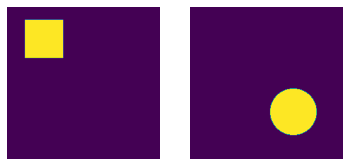

In [21]:
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(unmixed[i])
    plt.axis('off')
plt.show()

And we're back to square one. From the 8-channel image stack, we have determined the distribution of the pure components. This example is an ideal case with no noise, no background, and strong signals. In experimental images these other conbrutions will interfere with the unmixing and complicate the isolation of pure signals. 

## 2. Determined systems (channels = probes)
In case we have the same number of spectral changgels and fluorescent probes, we have a 'determined' system [(doi:10.1016/S0014-5793(03)00521-0)](https://doi.org/10.1016/S0014-5793(03)00521-0). Below, we illustrate the case where we have 4 probes and 4 emission channels.

Below, we load a synthetic image with four slices. Each slice is a square object at a different location. This square object reflects the distribution and intensity of the pure component.

In [22]:
im_raw = skimage.io.imread("Synthetic-4obj.tif")

Let's look at the dimensions:

In [23]:
im_raw.shape

(256, 256, 4)

The image stack consists of 4 channels that each are 256x256 pixels. To show the first image of the stack (python counts from zero):

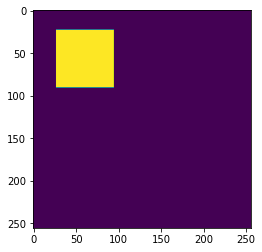

In [24]:
plt.imshow(im_raw[:,:,0])

The order of the dimensions can be changed. Below, we move the channel (originally the third dimensions) to the first (zero) position:

In [25]:
im_raw_t = np.transpose(im_raw, (2, 0, 1))

In [26]:
im_raw_t.shape

(4, 256, 256)

### 2.1 Mix

Let's plot all four images of the stack, showing the four objects:

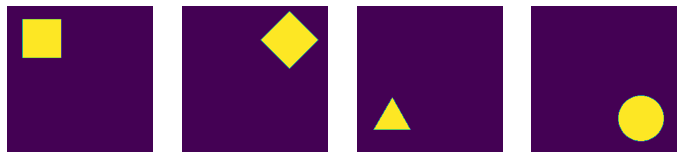

In [27]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(im_raw_t[i])
    plt.axis('off')
plt.show()

It is clear that each image/channel has a unique shape at a different location. These objects represent the pure components with a unique emission profile. In fluorescence imaging, there is often bleed-through between the channels. Here, we will add the bleed-through by multiplying the images with a mixing matrix. This mixing matrix is also artificial, but it recapitulates some aspects of fluorescence. It has a single peak and a tail at higher wavelengths.
The mixing matrix defines how the objects emission spreads over the different channels. In this matrix (mix), the column reflects the emission of an object in the four channels. The sum of each column is normalized to 1.

In [28]:
mix = np.array(
    [[.50, 0.0, 0.0, 0.0],
     [.25, 0.6, 0.1, 0.0],
     [.25, 0.2, 0.7, 0.1],
     [.00, 0.1, 0.2, 0.9]
    ])

Let's mix the synthetic image with the mixing matrix to get a realistic four channel stack of images. Here we use the 'np.einsum' function for matrix calculations. This is a bit of a complicated notation and this is because we are multiplying a 2D mixing matrix with 3D image data. The j and i specify the rows and columns of the mixing matrix and the ikl define the three dimensions of the image data and define that the channels of the image data need to be mixed by the mixing matrix.

In [29]:
mixed = np.einsum('ji,ikl->jkl', mix, im_raw_t)

Checking the shape of the new array:

In [30]:
mixed.shape

(4, 256, 256)

The new image stack has the same dimension as the original data and that is correct. Let's plot the result:

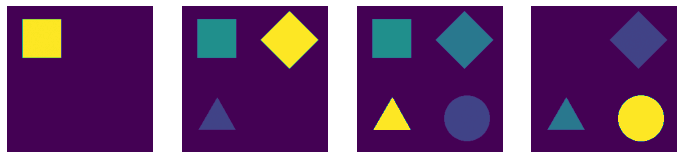

In [31]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(mixed[i], vmin=0, vmax=128)
    plt.axis('off')
plt.show()

It is clear that the objects now show a signal in multiple channels. For instance, the square in the upper left corner is has the strongest signal in the first image, but is also visible (with half of the signal) in the 2nd and 3rd channel. This distribution of the signal was defined in the mixing matrix (mix).

The resulting stack is a realistic set of images acquired from objects that emit at different wavelengths. When we know (and here we do!) the mixing matrix, we can use that to _unmix_ the data and calculate the distribution of the pure components.

### 2.2 Unmix

First, we need to calculate the inverted form of the mixing matrix:

In [32]:
inv_mix = np.linalg.inv(mix)
inv_mix

array([[ 2.        ,  0.        ,  0.        ,  0.        ],
       [-0.74498567,  1.747851  , -0.25787966,  0.0286533 ],
       [-0.53008596, -0.48710602,  1.54727794, -0.17191977],
       [ 0.20057307, -0.08595989, -0.31518625,  1.14613181]])

In [33]:
inv_mix.dtype

dtype('float64')

When the mixing matrix and its inverse are multiplied the identity matrix is the result:

In [34]:
np.dot(inv_mix,mix)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.77555756e-17,  1.00000000e+00,  2.33899377e-17,
        -1.79238191e-18],
       [-5.55111512e-17, -6.50546156e-18,  1.00000000e+00,
         2.94893050e-17],
       [ 1.38777878e-17,  6.36230960e-18,  1.27246192e-17,
         1.00000000e+00]])

Let's now apply this to unmixing. The image stack will be multiplied with the inverted matrix in the same way that we generated the mixed data. So the notation for the einsum function is the same:

In [35]:
unmixed = np.einsum('ji,ikl->jkl', inv_mix, mixed)

In [36]:
unmixed.shape

(4, 256, 256)

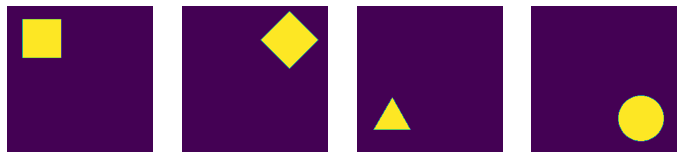

In [37]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(unmixed[i])
    plt.axis('off')
plt.show()

That's it. We have unmixed the stack and we have isolated the pure components.

## 3. Time-lapse imaging of a determined system

When objects are imaged at different timepoints, this adds another dimension to the data. In other words, time is added to the spatial and spectral dimensions. The principle of mixing and unmixing remains exactly the same, but the data is larger and more complex.

First, we load a synthetic dataset in which four object change location over time:

In [5]:
im_raw = skimage.io.imread("4obj_time.tif")

Let's check the shape:

In [6]:
im_raw.shape

(60, 256, 256, 4)

There are 60 timepoints with 256x256 images and 4 objects. Let's look at the 10th timepoint for the first object:

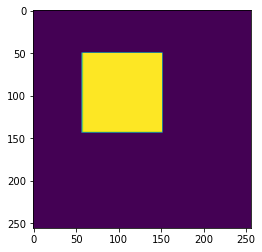

In [7]:
plt.imshow(im_raw[9,:,:,0])

To keep the data and the processing compatible with the previous code, I change the order of the dimensions so that the channel/object data comes first and time as last:

In [8]:
im_raw_t = np.transpose(im_raw, (3, 1, 2, 0))

In [9]:
im_raw_t.shape

(4, 256, 256, 60)

Let's plot a subset of these data. Specifically, timepoint 42:

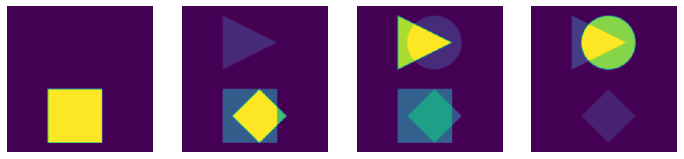

In [10]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(im_raw_t[i,:,:,42])
    plt.axis('off')
plt.show()

### 3.1 Mix

Let's mix the timelapse data with the mixing matrix. We'll use exactly the same matrix as in 2.1. Let's see if this matrix is still correctly defined:

In [44]:
mix

array([[0.5 , 0.  , 0.  , 0.  ],
       [0.25, 0.6 , 0.1 , 0.  ],
       [0.25, 0.2 , 0.7 , 0.1 ],
       [0.  , 0.1 , 0.2 , 0.9 ]])

Now, we will mix the 2D matrix with a 4D dataset. Since added a dimension to the matrix, we can add that to the einsum function as well:

In [45]:
mixed = np.einsum('ji,iklm->jklm', mix, im_raw_t)

Note that we can also write the higher dimension in the einsum function with ellipsis. This is particularly helpful if there are additional dimensions on top of time (for instance z, or anythin else):

In [46]:
mixed = np.einsum('ji,ikl...->jkl...', mix, im_raw_t)

In [47]:
mixed.shape

(4, 256, 256, 60)

The shape is as expected. Now let's look again at the data of timepoint 42:

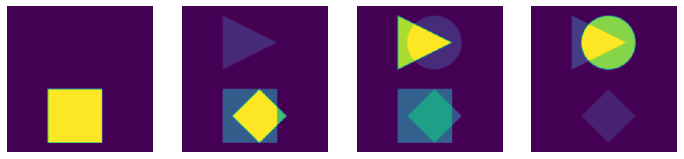

In [48]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(mixed[i,:,:,42])
    plt.axis('off')
plt.show()

Clearly, the signals are mixed and overlapping. Let's save this mixed timelapse data, but first we transpose the data:

In [49]:
mixed_t = np.transpose(mixed, (3, 1, 2, 0))
mixed_t.shape

(60, 256, 256, 4)

The einsum function can also be used to change the order of the dimensions and it may in fact be a bit more intuitive:

In [50]:
mixed_t = np.einsum('ijkl->ljki', mixed)
mixed_t.shape

(60, 256, 256, 4)

In this shape, the tif file can be opened as a hyperstack in FIJI/ImageJ

In [51]:
# To save the mixed image stack (~125 Mb) uncomment:
# skimage.io.imsave('mixed_4obj_time.tif', mixed_t)

### 3.2 Unmix

The unmixing with the inverted matrix (that we calculated in 2.2) is straightforward:

In [52]:
unmixed = np.einsum('ji,ikl...->jkl...', inv_mix, mixed)

In [53]:
unmixed.shape

(4, 256, 256, 60)

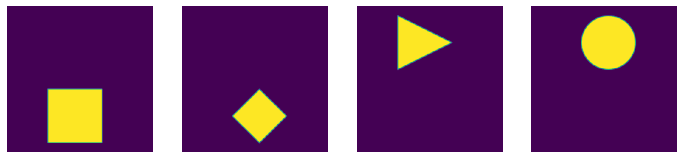

In [54]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(unmixed[i,:,:,42])
    plt.axis('off')
plt.show()